In [38]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from IPython.display import HTML, display
import json
from collections import Counter
import pandas as pd
import numpy as np
from utilities import *

register_matplotlib_converters()
pd.set_option('display.float_format', '{:.0f}'.format)
pd.set_option('display.max_colwidth', 100)
%matplotlib inline


In [39]:
df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_rate.csv', parse_dates=['date'])

def calculate_rate(df, value_col, population_col, rate_per=1000):
    num_per_thousand = (df[value_col]/df[population_col])*rate_per
    return num_per_thousand

df['rate'] = calculate_rate(df, 'doac', 'population')

codelist = pd.read_csv('../codelists/opensafely-mechanical-or-artificial-valves.csv')


FileNotFoundError: [Errno 2] No such file or directory: '../output/measure_doac_rx_mechanical_valve_warfarin_rate.csv'

## DOAC Use in Patients with Mechanical Heart Valves


### Total Number

In [ ]:
def redact_small_numbers(df, n, numerator, denominator, rate_column):
    """
    Takes counts df as input and suppresses low numbers.  Sequentially redacts
    low numbers from numerator and denominator until count of redcted values >=n.
    Rates corresponding to redacted values are also redacted.
    
    df: input df
    n: threshold for low number suppression
    numerator: numerator column to be redacted
    denominator: denominator column to be redacted
    """
    
    def suppress_column(column):    
        suppressed_count = column[column<=n].sum()
        
        #if 0 dont need to suppress anything
        if suppressed_count == 0:
            pass
        
        else:
            column[column<=n] = np.nan
            

            while suppressed_count <=n:
                suppressed_count += column.min()
                column.iloc[column.idxmin()] = np.nan   
        return column
    
    
    for column in [numerator, denominator]:
        df[column] = suppress_column(df[column])
    
    df.loc[(df[numerator].isna())| (df[denominator].isna()), rate_column] = np.nan
    
    return df

population = df.groupby(by='date')[['population']].sum().reset_index()
events = df.groupby(by='date')[['doac']].sum().reset_index()
total_df = df.groupby(by='date')[['rate']].mean().reset_index()

total_df = total_df.merge(events, on='date').merge(population, on='date')


redacted_dfs = []
for date in total_df['date'].unique():
    
    sub_df = total_df.loc[total_df['date']==date, :]

    sub_df = redact_small_numbers(sub_df, 5, 'doac', 'population', 'rate')
    redacted_dfs.append(sub_df)

total_df = pd.concat(redacted_dfs, axis=0)
total_df.to_csv('../output/doac_rate_total.csv')




# total_df = redact_small_numbers(total_df, 10, 'doac', 'population', 'rate')


def plot_measures(df, title,column_to_plot, filename,category=False, y_label='Rate per 1000', interactive=True):

    if category:
        for unique_category in df[category].unique():

            df_subset = df[df[category] == unique_category]

            plt.plot(df_subset['date'], df_subset[column_to_plot], marker='o')
    else:
        plt.plot(df['date'], df[column_to_plot])

    plt.ylabel(y_label)
    plt.xlabel('Date')
    plt.ylim(bottom=0, top=df[column_to_plot].max() + df[column_to_plot].max()* 0.1)
    plt.xticks(rotation='vertical')
    plt.title(title)

    if category:
        plt.legend(df[category].unique(), bbox_to_anchor=(
            1.04, 1), loc="upper left")

    else:
        pass
    plt.savefig(f'../output/measure_{filename}.jpeg')
    plt.show()
    
    plt.clf()

of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = suppress_column(df[column])
/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-16-4bafbfd1d2cc>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[

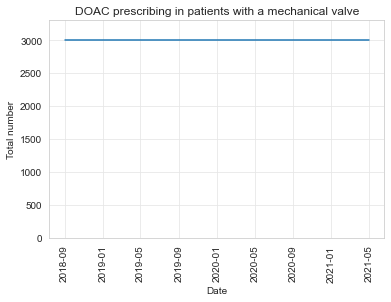

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_measures(total_df, title='DOAC prescribing in patients with a mechanical valve', column_to_plot='doac', category=False, y_label='Total number', interactive=False, filename="total")


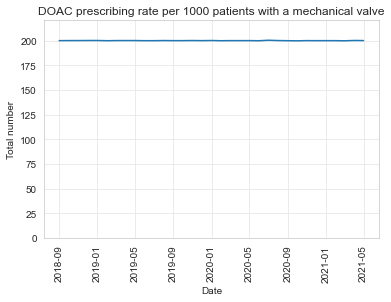

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_measures(total_df, title='DOAC prescribing rate per 1000 patients with a mechanical valve', column_to_plot='rate', category=False, y_label='Rate per 1000', interactive=False, filename="total_rate")

### Mechanical Valve Type

Mechanical valve type of those with mechanical valve currently prescribed a DOAC

In [ ]:
def group_low_values_mv(df, value_col, population_col, term_col):
    
    
    suppressed_count = df.loc[df[value_col]<=5, value_col].sum()
    population_suppressed_count = df.loc[df[value_col]<=5, population_col].sum()
    
    if suppressed_count == 0:
        pass

    else:
        df.loc[df[value_col] <=5, value_col]  = np.nan

        while suppressed_count <=5:
            suppressed_count += df[value_col].min()
            df.loc[df[value_col].idxmin(), value_col] = np.nan 
            
            population_suppressed_count += df.loc[df[value_col].idxmin(), population_col]
   
        df = df[df[value_col].notnull()]

        other_row = {'mechanical_valve_code':'Other', 'doac_3_months':suppressed_count, 'population':population_suppressed_count, 'term':'-'}
        df = df.append(other_row, ignore_index=True)
    
    
    return df

In [ ]:
valve_type_df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_3_month_valve_code_rate.csv', parse_dates=['date'])


valve_type_df_now = valve_type_df[valve_type_df['date']== '2021-12-01']
valve_type_df_now = valve_type_df_now.drop('value', axis=1)

valve_type_df_now = valve_type_df_now.merge(codelist, left_on='mechanical_valve_code', right_on='code', how='left')
valve_type_df_now = valve_type_df_now.drop(columns=['code', 'date'])
valve_type_df_now = group_low_values_mv(valve_type_df_now, 'doac_3_months', 'population', 'term')
valve_type_df_now.to_csv('../output/current_doac_valve_type.csv')

In [ ]:
valve_type_df_now

,mechanical_valve_code,doac_3_months,population,term
0,NaN,2423,12000,NaN
1,174920003,577,3000,Prosthetic mitral valve replacement (& [Bjork Shiley] or [Carpentier Edwards])


### Demographic breakdown

#### Sex

In [ ]:
def group_low_values_dems(df, value_col, population_col, demographic):
  
    suppressed_count = df.loc[df[value_col]<=5, value_col].sum()
    population_suppressed_count = df.loc[df[value_col]<=5, population_col].sum()
    if suppressed_count == 0:
        pass

    else:
        df.loc[df[value_col] <=5, value_col]  = np.nan
       
        if suppressed_count <=5:
           
            suppressed_count += df[value_col].min()
            population_suppressed_count += df.loc[df[value_col].idxmin(), population_col]
            df.loc[df[value_col].idxmin(), value_col] = np.nan 
            
            
        df = df[df[value_col].notnull()]

        other_row = {demographic:'Other', 'doac_3_months':suppressed_count, 'population':population_suppressed_count,}
        df = df.append(other_row, ignore_index=True)
    
    
    return df

In [ ]:
sex_df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_3_month_sex_rate.csv', parse_dates=['date'])

sex_df_now = sex_df[sex_df['date'] == '2021-12-01']
sex_df_now = sex_df_now.drop(['value', 'date'], axis=1)
sex_df_now = group_low_values_dems(sex_df_now, 'doac_3_months', 'population', 'sex')
sex_df_now.to_csv('../output/current_doac_sex.csv')
sex_df_now


,sex,doac_3_months,population
96,F,1515,7486
97,M,1461,7379
98,U,24,135


#### Ethnicity

In [43]:
ethnicity_df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_3_month_ethnicity_rate.csv', parse_dates=['date'])
ethnicity_df_now = ethnicity_df[ethnicity_df['date'] == '2021-12-01']
ethnicity_df_now = ethnicity_df_now.drop(['value', 'date'], axis=1)

ethnicity_df_now = group_low_values_dems(ethnicity_df_now, 'doac_3_months', 'population', 'eth2001')
ethnicity_df_now.to_csv('../output/current_doac_ethnicity.csv')
ethnicity_df_now


   eth2001  doac_3_months  population
0      NaN           2699       13504
1        1            165         734
2        2             76         382
3        3             28         189
4        4             16         106
5        5              7          49
6      NaN           2699       13504
7        1            165         734
8        2             76         382
9        3             28         189
10       4             16         106
11       5              7          49
12   Other             18          72


,eth2001,doac_3_months,population
0,NaN,2699,13504
1,1,165,734
2,2,76,382
3,3,28,189
4,4,16,106
5,5,7,49
6,NaN,2699,13504
7,1,165,734
8,2,76,382
9,3,28,189


#### Age Band

In [44]:
age_df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_3_month_age_rate.csv', parse_dates=['date'])

age_df_now = age_df[age_df['date'] == '2021-12-01']
age_df_now = age_df_now.drop(['value', 'date'], axis=1)
age_df_now = group_low_values_dems(age_df_now, 'doac_3_months', 'population', 'age_band')
age_df_now.to_csv('../output/current_doac_age.csv')
age_df_now

,age_band,doac_3_months,population
0,20-29,379,1899
1,30-39,372,1804
2,40-49,376,1818
3,50-59,373,1850
4,60-69,382,1947
5,70-79,375,1841
6,80+,390,1941
7,Other,353,1812


## AF

In [ ]:
af_df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_3_month_af_rate.csv', parse_dates=['date'])
af_df_now = af_df[af_df['date'] == '2021-12-01']
af_df_now = af_df_now.drop(['value', 'date'], axis=1)
af_df_now = group_low_values_dems(af_df_now, 'doac_3_months', 'population', 'atrial_fib')
af_df_now.to_csv('../output/current_doac_af.csv')
af_df_now

## IMD

In [ ]:
imd_df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_3_month_imd_rate.csv', parse_dates=['date'])
imd_df_now = imd_df[imd_df['date'] == '2021-12-01']
imd_df_now = imd_df_now.drop(['value', 'date'], axis=1)
imd_df_now = group_low_values_dems(imd_df_now, 'doac_3_months', 'population', 'imd')
imd_df_now.to_csv('../output/current_doac_imd.csv')
imd_df_now